In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import defaultdict
from scipy.spatial.distance import cdist
import os
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import math
import seaborn as sns

dataset_path = "population_log_DE_sphere.csv"

df = pd.read_csv(dataset_path)

print("Prvních 10 záznamů:")
print(df.head(10))

print("\nPosledních 10 záznamů:")
print(df.tail(10))

print("\nInformace o datasetu:")
print(df.info())

print("\nNáhodný vzorek dat:")
print(df.sample(5))

Prvních 10 záznamů:
   generation  id    gene_0    gene_1    gene_2    gene_3    gene_4    gene_5  \
0           0   0  2.607859  2.026220  4.858503  1.356779 -0.365658  2.233271   
1           0   1 -2.293901  0.003163 -4.882998 -4.284213 -2.028967 -3.585765   
2           0   2  3.429390 -3.020446 -0.531138 -1.005205  2.582251 -2.383498   
3           0   3 -1.710594 -3.625843 -4.490107  0.398964 -4.693686 -5.105428   
4           0   4 -1.930501 -0.083531  0.447386 -0.704936 -3.708517  3.073681   
5           0   5 -1.949609 -2.079457  0.331113 -0.424375 -2.497123  1.230296   
6           0   6 -2.769096  4.587408 -2.614021  1.623722 -1.923066  0.841371   
7           0   7 -2.990717  2.975768 -2.006520  2.548545 -2.504573  1.092251   
8           0   8 -0.769368  3.257137  0.541176 -2.898169 -0.357850 -4.484695   
9           0   9  4.307138  0.013702  0.566171  2.153872  0.968628  4.887759   

     gene_6    gene_7    gene_8    gene_9  
0 -0.365918 -2.819114  3.516885  0.538309  


In [2]:
from kneed import KneeLocator

def compute_inertia(data, labels, centroids):
    inertia = 0
    for i in range(len(centroids)):
        cluster_points = data[labels == i]
        inertia += np.sum((cluster_points - centroids[i])**2)
    return inertia

def elbow_plot(data, k_range):
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_

        inertia = compute_inertia(data, labels, centroids)
        inertias.append(inertia)

    # Automatická detekce loktu
    kl = KneeLocator(k_range, inertias, curve="convex", direction="decreasing")
    elbow_k = kl.elbow

    # Graf
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertias, marker='o', label="WCSS")
    if elbow_k is not None:
        plt.axvline(x=elbow_k, color='r', linestyle='--', label=f"Loket na k = {elbow_k}")
    plt.title("Metoda lokte optimální k")
    plt.xlabel("Počet shluků (k)")
    plt.ylabel("Inercie (WCSS)")
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Loket nalezen na k = {elbow_k}")

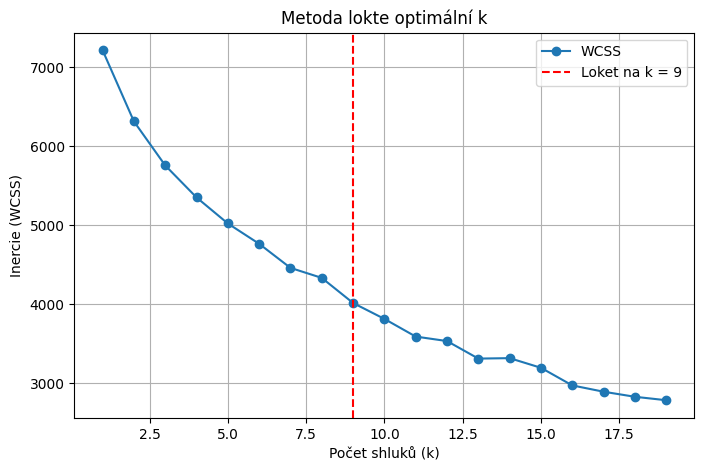

Loket nalezen na k = 9


In [3]:
df = pd.read_csv("population_log_DE_sphere.csv")
pop_data = df[df["generation"] == 0].drop(columns=["generation", "id"]).values

elbow_plot(pop_data, range(1, 20))

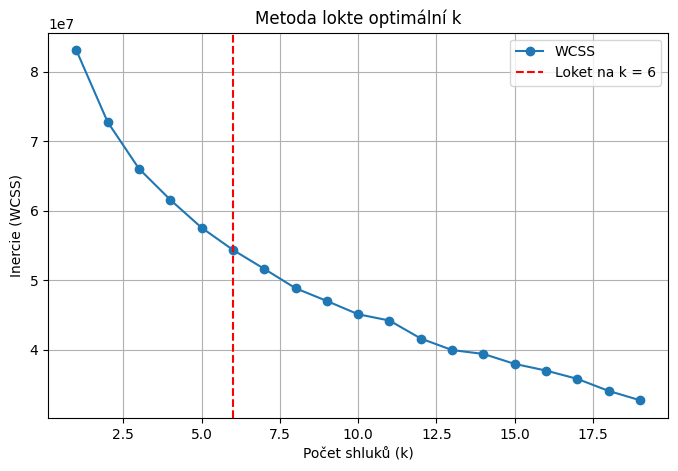

Loket nalezen na k = 6


In [4]:
df = pd.read_csv("population_log_DE_schwefel.csv")
pop_data = df[df["generation"] == 0].drop(columns=["generation", "id"]).values

elbow_plot(pop_data, range(1, 20))

In [8]:
from collections import defaultdict
import numpy as np

def map_and_remap_clusters(
    gen_index,
    prev_clusters_members, curr_clusters_members,
    clusters_array, pop_data,
    global_id_counter
):
    if gen_index > 0 and global_id_counter == 0:
        global_id_counter = max(prev_clusters_members.keys()) + 1

    if gen_index == 0:
        new_ids = {}
        for cid in curr_clusters_members.keys():
            new_ids[cid] = global_id_counter
            global_id_counter += 1

        new_clusters_array = np.array([
            new_ids[cl] if cl in new_ids else -1 for cl in clusters_array
        ])
        new_centroids = np.array([
            np.mean(pop_data[np.array(new_clusters_array) == gid], axis=0)
            for gid in sorted(new_ids.values())
        ])
        new_cluster_members = {
            new_ids[cid]: members for cid, members in curr_clusters_members.items()
        }

        return new_clusters_array, new_centroids, new_cluster_members, global_id_counter

    # === 1. Každý starý cluster navrhne JEDEN nejlepší nový cluster ===
    suggestions = defaultdict(list)

    for prev_id, prev_members in prev_clusters_members.items():
        best_score = -1
        best_curr_id = None
        for curr_id, curr_members in curr_clusters_members.items():
            intersection = len(prev_members & curr_members)
            union = len(prev_members | curr_members)
            if union == 0:
                continue
            jaccard = intersection / union
            if jaccard > best_score:
                best_score = jaccard
                best_curr_id = curr_id
        if best_curr_id is not None:
            suggestions[best_curr_id].append((prev_id, best_score))

    # === Debug výpis návrhů ===
    #print("\n--- Návrhy pro nové clustery (přesně jeden od každého předka) ---")
    #for curr_id, proposals in suggestions.items():
        #print(f"Nový cluster {curr_id}: {[f'{pid} ({score:.2f})' for pid, score in sorted(proposals, key=lambda x: -x[1])]}")

    # === 2. Výběr nejlepšího nepoužitého předka
    used_prev_ids = set()
    id_mapping = {}
    for curr_id, proposals in suggestions.items():
        proposals.sort(key=lambda x: -x[1])  # podle Jaccarda sestupně
        for prev_id, score in proposals:
            if prev_id not in used_prev_ids:
                id_mapping[curr_id] = prev_id
                used_prev_ids.add(prev_id)
                #print(f"✔️ Cluster {curr_id} byl namapován na {prev_id} (Jaccard: {score:.2f})")
                break

    # === 3. Zbytek nových clusterů dostane nové ID
    for curr_id in curr_clusters_members:
        if curr_id not in id_mapping:
            id_mapping[curr_id] = global_id_counter
            #print(f"🆕 Cluster {curr_id} nedostal žádného předka – přiděleno nové ID: {global_id_counter}")
            global_id_counter += 1

    # === 4. Mapování pole clusterů
    new_clusters_array = np.array([
        id_mapping[cl] if cl in id_mapping else -1 for cl in clusters_array
    ])

    # === 5. Přepočet centroidů
    new_centroids = []
    new_cluster_ids = sorted(set(id_mapping.values()))
    for gid in new_cluster_ids:
        member_data = pop_data[np.array(new_clusters_array) == gid]
        if len(member_data) > 0:
            new_centroids.append(np.mean(member_data, axis=0))
    new_centroids = np.array(new_centroids)

    # === 6. Členové clusterů podle nového mapování
    new_cluster_members = {}
    for curr_id, members in curr_clusters_members.items():
        gid = id_mapping[curr_id]
        new_cluster_members[gid] = members

    return new_clusters_array, new_centroids, new_cluster_members, global_id_counter


def schwefel(coordinates):
    result = 0
    for coordinate in coordinates:
        result += coordinate * math.sin(math.sqrt(abs(coordinate)))
    return 418.9829 * len(coordinates) - result

def sphere(x):
    return sum([xi**2 for xi in x])

def kmeans_custom(data, k, max_iters=100, tol=1e-4):
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    
    for _ in range(max_iters):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        
        centroids = new_centroids
    
    return labels, centroids

def run(dataset, num_clusters, step, fintess_method, clustering_method_name, evol_name):
    output_dir = os.path.join("html_report", evol_name, fintess_method.__name__, clustering_method_name)
    images_dir = os.path.join(output_dir, "images")
    os.makedirs(images_dir, exist_ok=True)


    html_parts = [
        "<html><head><meta charset='utf-8'><title>Kmeans clustering report</title></head><body>",
        "<h1>Kmeans shlukování – Vývoj</h1>"
    ]
    df = pd.read_csv(dataset)

    unique_generations = sorted(df["generation"].unique())

    #selected_generations = [unique_generations[0]] + unique_generations[step-1::step] + [unique_generations[-1]]
    selected_generations = list(dict.fromkeys(
        [unique_generations[0]] + unique_generations[step-1::step] + [unique_generations[-1]]
    ))


    centroid_history = []
    cluster_counts = []
    size_history = []
    inertia_history = []
    cluster_members_by_gen = {}
    global_cluster_map = {}  # {generation: {local_cluster_id: global_id}}
    global_id_counter = 0

    first_gen_data = df[df["generation"] == unique_generations[0]].drop(columns=["generation", "id"]).values
    pca = PCA(n_components=2)
    pca.fit(first_gen_data)

    id_cluster_map = defaultdict(list)


    #for gen in selected_generations:
    for gen_ind, gen in enumerate(selected_generations):
        pop_data = df[df["generation"] == gen].drop(columns=["generation", "id"]).values
        reduced_data = pca.transform(pop_data)

        #clusters, centroids = kmeans_custom(pop_data, num_clusters)
        # Inicializace modelu
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)

        # Fitnutí modelu na data
        kmeans.fit(pop_data)

        # Získání příslušnosti k jednotlivým clusterům
        clusters = kmeans.labels_

        # Získání centroidů
        centroids = kmeans.cluster_centers_

        cluster_counts.append(len(set(clusters)))


        ids = df[df["generation"] == gen]["id"].values

        #for ident, cl in zip(ids, clusters):
        #    id_cluster_map[ident].append(cl)

        # === Uložení členů clusterů pro aktuální generaci ===
        #cluster_to_ids = defaultdict(set)
        #for ident, cl in zip(ids, clusters):
        #    cluster_to_ids[cl].add(ident)
        #cluster_members_by_gen[gen] = cluster_to_ids

        #next_global_id = map_global_cluster_ids(
        #i, selected_generations,
        #cluster_members_by_gen,
        #global_cluster_map,
        #next_global_id
        #)

        # Nahrazení lokálních ID za globální ID podle mapy
        #clusters = np.array([global_cluster_map[gen][cl] for cl in clusters])


        # === Uložení členů clusterů pro aktuální generaci – LOKÁLNÍ ID (kvůli Jaccardu)
        #cluster_to_ids = defaultdict(set)
        #for ident, cl in zip(ids, clusters):
        #    cluster_to_ids[cl].add(ident)
        #cluster_members_by_gen[gen] = cluster_to_ids  # pro mapování

        # === Přemapování clusterů pomocí Jaccard (bez globální mapy)
        prev_clusters_members = cluster_members_by_gen[selected_generations[gen_ind - 1]] if gen_ind > 0 else None
        curr_clusters_members = defaultdict(set)
        for ident, cl in zip(ids, clusters):
            if cl != -1:
                curr_clusters_members[cl].add(ident)

        if prev_clusters_members is not None:
            clusters, centroids, curr_clusters_members, global_id_counter = map_and_remap_clusters(
                gen_ind,
                prev_clusters_members,
                curr_clusters_members,
                clusters,
                pop_data,
                global_id_counter
            )


        cluster_members_by_gen[gen] = curr_clusters_members

        # === Až teď uložíme do `id_cluster_map`
        for ident, cl in zip(ids, clusters):
            id_cluster_map[ident].append(cl)



        # === Sledování centroidů, velikosti a kvality ===
        centroid_history.append(centroids)
        size_history.append([np.sum(clusters == i) for i in range(num_clusters)])
        inertia = compute_inertia(pop_data, clusters, centroids)
        inertia_history.append(inertia)



        #plt.figure(figsize=(6, 6))
        #scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
        #for i in range(num_clusters):
        #    plt.scatter(
        #        centroids[i, 0], centroids[i, 1], 
        #        c=[scatter.to_rgba(i)], marker='X', s=100, edgecolors='black', linewidth=1.5, label=f"Centroid {i}"
        #    )
        #plt.title(f"Generation {gen} - Custom K-Means Clustering")
        #plt.xlabel("PCA Component 1")
        #plt.ylabel("PCA Component 2")
        #plt.legend()
        #plt.show()

        centroids_2d = pca.transform(centroids)

        plt.figure(figsize=(6, 6))
        scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)

        handles, _ = scatter.legend_elements(prop="colors")
        legend_labels = [f"Shluk {cl}" for cl in sorted(set(clusters))]  # ← reálné názvy

        plt.legend(handles, legend_labels, title="Shluky", loc='upper center', bbox_to_anchor=(0.5, -0.12),
                ncol=5, fontsize=8, frameon=False)
        plt.title(f"Generace {gen} - K-means Shlukování")
        plt.xlabel("PCA komponent 1")
        plt.ylabel("PCA komponent 2")
        plt.tight_layout()
        scatter_path = os.path.join(images_dir, f"scatter_gen_{gen:03d}.png")
        plt.savefig(scatter_path)
        plt.close()

        html_parts.append(f"<h2>Generace {gen}</h2>")
        html_parts.append(f"<img src='images/{os.path.basename(scatter_path)}' width='600'><br>")


        # === Histogram velikostí clusterů ===
        unique_labels = sorted(set(clusters))
        cluster_sizes = [np.sum(clusters == label) for label in unique_labels]

        # Filtrování jen neprázdných shluků
        filtered = [(label, size) for label, size in zip(unique_labels, cluster_sizes) if size > 0]
        if not filtered:
            filtered_labels, filtered_sizes = [], []
        else:
            filtered_labels, filtered_sizes = zip(*filtered)

        # Vykreslení histogramu s indexy místo skutečných labelů jako souřadnic
        plt.figure(figsize=(6, 4))
        x_pos = range(len(filtered_labels))  # [0, 1, 2, ...]
        bars = plt.bar(x_pos, filtered_sizes, color='skyblue', edgecolor='black')

        # Popisky pod osou
        plt.xticks(ticks=x_pos, labels=[f"Shluk {label}" for label in filtered_labels], rotation=90)

        plt.ylabel("Počet jedinců")
        plt.title(f"Histogram velikostí shluků - generace {gen}")
        plt.grid(True, axis='y')
        plt.tight_layout()

        # Uložení
        hist_path = os.path.join(images_dir, f"histogram_gen_{gen:03d}.png")
        plt.savefig(hist_path)
        plt.close()

        # Přidání do HTML
        html_parts.append(f"<img src='images/{os.path.basename(hist_path)}' width='600'><br>")


        # === Analýza stability clusterů mezi generacemi ===
        if gen_ind > 0:
            previous_gen = selected_generations[gen_ind - 1]
            current_gen = gen

            cluster_transitions = defaultdict(lambda: defaultdict(int))  # prev_cluster -> current_cluster -> count

            for ident, history in id_cluster_map.items():
                if len(history) > gen_ind:
                    prev_label = history[gen_ind - 1]
                    curr_label = history[gen_ind]
                    cluster_transitions[prev_label][curr_label] += 1

            html_parts.append(f"<h3>Stabilita mezi generací {previous_gen} → {current_gen}:</h3>")
            html_parts.append("<pre>")
            for prev_label, curr_counts in cluster_transitions.items():
                total = sum(curr_counts.values())
                for curr_label, count in curr_counts.items():
                    percent = count / total * 100 if total > 0 else 0
                    html_parts.append(f"  Shluk {prev_label} → {curr_label}: {count} jedinců ({percent:.1f} %)")
            html_parts.append("</pre>")

        # === Mapování pomocí Jaccardova indexu mezi předchozí a aktuální generací ===
        if gen_ind > 0:
            gen_a = selected_generations[gen_ind - 1]
            gen_b = gen

            clusters_a = cluster_members_by_gen[gen_a]
            clusters_b = cluster_members_by_gen[gen_b]

            html_parts.append(f"<h3>Jaccardovo mapování a overlap: Generace {gen_a} → {gen_b}</h3>")
            html_parts.append("<pre>")

            for ca, members_a in clusters_a.items():
                best_jaccard = 0
                best_cb = None

                for cb, members_b in clusters_b.items():
                    intersection = len(members_a & members_b)
                    union = len(members_a | members_b)
                    jaccard = intersection / union if union > 0 else 0
                    overlap = len(members_a & members_b) / min(len(members_a), len(members_b))

                    if jaccard > best_jaccard:
                        best_jaccard = jaccard
                        best_cb = cb

                if best_cb is not None:
                    intersection = len(members_a & clusters_b[best_cb])
                    denom = min(len(members_a), len(clusters_b[best_cb]))
                    overlap = intersection / denom if denom > 0 else 0
                    html_parts.append(f" - Cluster {ca} → {best_cb} (Jaccard: {best_jaccard:.2f}, Overlap: {overlap:.2f})")
                else:
                    html_parts.append(f" - Cluster {ca} → žádný vhodný přechod")

            html_parts.append("</pre>")
        
        # === Posun centroidů mezi předchozí a aktuální generací ===
            if gen_ind > 0:
                html_parts.append(f"<h4>Posun centroidů mezi generací {selected_generations[gen_ind - 1]} → {gen}:</h4>")
                html_parts.append("<pre>")
                centroids_a = centroid_history[gen_ind - 1]
                centroids_b = centroid_history[gen_ind]
                for j in range(min(len(centroids_a), len(centroids_b))):
                    dist = np.linalg.norm(centroids_a[j] - centroids_b[j])
                    html_parts.append(f" - Shluk {j}: {dist:.4f}")
                html_parts.append("</pre>")


        # === Boxplot fitness hodnot v jednotlivých clusterech ===
        gen_data = df[df["generation"] == gen]
        pop_values = gen_data.drop(columns=["generation", "id"]).values
        fitness_values = np.array([fintess_method(ind) for ind in pop_values])
        cluster_ids = sorted(set(clusters) - {-1})
        cluster_fitness = {cl: [] for cl in cluster_ids}
        for i, cl in enumerate(clusters):
            if cl in cluster_fitness:
                cluster_fitness[cl].append(fitness_values[i])
        plt.figure(figsize=(8, 5))
        plt.boxplot([cluster_fitness[cl] for cl in cluster_ids],
                    labels=[f"Shluk {cl}" for cl in cluster_ids])
        plt.xticks(rotation=90)
        plt.xlabel("Shluk")
        plt.ylabel("Fitness")
        plt.title(f"Distribuce fitness hodnot – generace {gen}")
        plt.grid(True)
        plt.tight_layout()
        box_path = os.path.join(images_dir, f"boxplot_gen_{gen:03d}.png")
        plt.savefig(box_path)
        plt.close()
        html_parts.append(f"<img src='images/{os.path.basename(box_path)}' width='600'><br>")


        #switch_counts = {}
        #for ident, history in id_cluster_map.items():
        #    switches = sum(1 for a, b in zip(history, history[1:]) if a != b)
        #    switch_counts[ident] = switches

        #total = len(switch_counts)
        #same = sum(1 for s in switch_counts.values() if s == 0)
        #once = sum(1 for s in switch_counts.values() if s == 1)
        #many = sum(1 for s in switch_counts.values() if s > 1)

        #print("Statistiky pohybu mezi clustery:")
        #print(f"Celkem jedinců: {total}")
        #print(f"Zůstali ve stejném clusteru: {same} ({same/total*100:.1f} %)")
        #print(f"Změnili cluster jednou: {once} ({once/total*100:.1f} %)")
        #print(f"Změnili cluster vícekrát: {many} ({many/total*100:.1f} %)")

    plt.figure(figsize=(8, 4))
    plt.plot(selected_generations, cluster_counts, marker='o')
    plt.xlabel("Generace")
    plt.ylabel("Počet Shluků")
    plt.title("Vývoj počtu shlukků v čase")
    plt.grid(True)
    plt.tight_layout()
    time_cluster_path = os.path.join(images_dir, f"time_cluster_gen_{gen:03d}.png")
    plt.savefig(time_cluster_path)
    plt.close()
    html_parts.append(f"<img src='images/{os.path.basename(time_cluster_path)}' width='600'><br>")

    all_global_ids = sorted({cid for gen_map in cluster_members_by_gen.values() for cid in gen_map})
    global_id_to_index = {cid: i for i, cid in enumerate(all_global_ids)}

    cluster_size_array = np.zeros((len(selected_generations), len(all_global_ids)))

    for gen_idx, gen in enumerate(selected_generations):
        gen_clusters = cluster_members_by_gen[gen]
        for gid, members in gen_clusters.items():
            idx = global_id_to_index[gid]
            cluster_size_array[gen_idx, idx] = len(members)

    plt.figure(figsize=(12, 5))
    for j, gid in enumerate(all_global_ids):
        plt.plot(selected_generations, cluster_size_array[:, j], label=f"Shluk {gid}")

    # === Vývoj velikosti clusterů ===
    plt.xlabel("Generace")
    plt.ylabel("Počet jedinců")
    plt.title("Vývoj velikosti shluků v čase")
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
    #        ncol=5, fontsize=8, frameon=False)
    plt.grid(True)
    plt.tight_layout()
    size_cluster_path = os.path.join(images_dir, f"size_cluster_gen_{gen:03d}.png")
    plt.savefig(size_cluster_path)
    plt.close()
    html_parts.append(f"<img src='images/{os.path.basename(size_cluster_path)}' width='1200'><br>")

    plt.figure(figsize=(14, 6))
    sns.heatmap(cluster_size_array.T, cmap="viridis", cbar_kws={"label": "Počet jedinců"})
    plt.xlabel("Generace")
    plt.ylabel("Globální ID shluku")
    plt.title("Heatmapa vývoje velikosti shluků v čase")
    plt.tight_layout()
    size_cluster_heatmap = os.path.join(images_dir, f"Size_cluster_heatmap_gen_{gen:03d}.png")
    plt.savefig(size_cluster_heatmap)
    plt.close()
    html_parts.append(f"<img src='images/{os.path.basename(size_cluster_heatmap)}' width='1200'><br>")

    num_clusters = cluster_size_array.shape[1]
    chunk_size = 50  # uprav dle potřeby (např. 50)
    num_chunks = (num_clusters + chunk_size - 1) // chunk_size  # zaokrouhlení nahoru

    if num_clusters > 50:
        for i in range(num_chunks):
            start = i * chunk_size
            end = min(start + chunk_size, num_clusters)

            # Získání skutečných globálních ID pro tento chunk
            chunk_ids = all_global_ids[start:end]
            chunk_array = cluster_size_array[:, start:end].T  # každý řádek = jeden cluster

            plt.figure(figsize=(14, 6))
            sns.heatmap(chunk_array, cmap="viridis", 
                        cbar_kws={"label": "Počet jedinců"},
                        yticklabels=chunk_ids)  # správné ID na ose Y
            plt.xlabel("Generace")
            plt.ylabel("Globální ID shluku")
            plt.title(f"Heatmapa vývoje velikosti shluků (Clustery {chunk_ids[0]}–{chunk_ids[-1]})")
            plt.tight_layout()

            heatmap_path = os.path.join(images_dir, f"size_cluster_heatmap_{chunk_ids[0]:03d}_{chunk_ids[-1]:03d}.png")
            plt.savefig(heatmap_path)
            plt.close()

            html_parts.append(f"<img src='images/{os.path.basename(heatmap_path)}' width='1200'><br>")


    average_intercentroid_distances = []
    for centroids in centroid_history:
        if len(centroids) < 2:
            average_intercentroid_distances.append(0)
            continue
        dists = cdist(centroids, centroids)
        upper_triangle = dists[np.triu_indices_from(dists, k=1)]
        avg_dist = np.mean(upper_triangle)
        average_intercentroid_distances.append(avg_dist)

    plt.figure(figsize=(8, 4))
    plt.plot(selected_generations, average_intercentroid_distances, marker='o', color='purple')
    plt.xlabel("Generace")
    plt.ylabel("Průměrná vzdálenost mezi centroidy")
    plt.title("Vývoj vzdáleností mezi centroidy")
    plt.grid(True)
    plt.tight_layout()
    distance_centroid_path = os.path.join(images_dir, f"distance_centroid_gen_{gen:03d}.png")
    plt.savefig(distance_centroid_path)
    plt.close()
    html_parts.append(f"<img src='images/{os.path.basename(distance_centroid_path)}' width='600'><br>")


    # === Vývoj WCSS ===
    plt.figure(figsize=(8, 4))
    plt.plot(selected_generations, inertia_history, marker='o')
    plt.xlabel("Generace")
    plt.ylabel("WCSS (inercie)")
    plt.title("Vývoj kvality shluků (inercie) – K-means")
    plt.grid(True)
    plt.tight_layout()
    wcss_path = os.path.join(images_dir, f"wcss_gen_{gen:03d}.png")
    plt.savefig(wcss_path)
    plt.close()
    html_parts.append(f"<img src='images/{os.path.basename(wcss_path)}' width='600'><br>")


    html_path = os.path.join(output_dir, "report.html")
    with open(html_path, "w", encoding="utf-8") as f:
        f.write("\n".join(html_parts))

    print(f"✅ HTML report byl uložen do: {html_path}")

In [9]:
run("population_log_DE_sphere.csv", 9, 1, sphere, "Kmeans", "DE")

✅ HTML report byl uložen do: html_report\DE\sphere\Kmeans\report.html


In [10]:
run("population_log_DE_schwefel.csv", 6, 1, schwefel, "Kmeans", "DE")

✅ HTML report byl uložen do: html_report\DE\schwefel\Kmeans\report.html


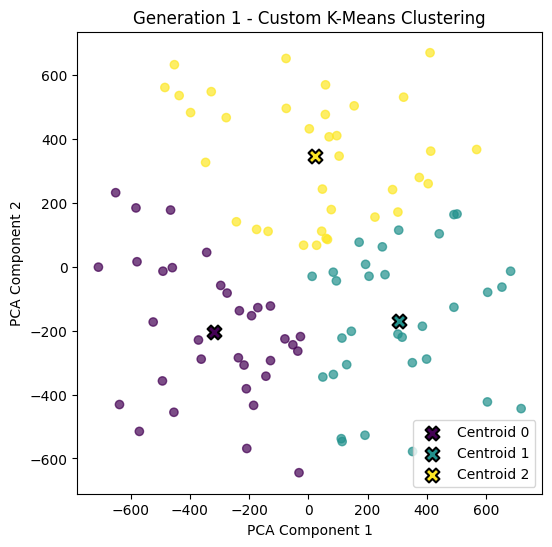

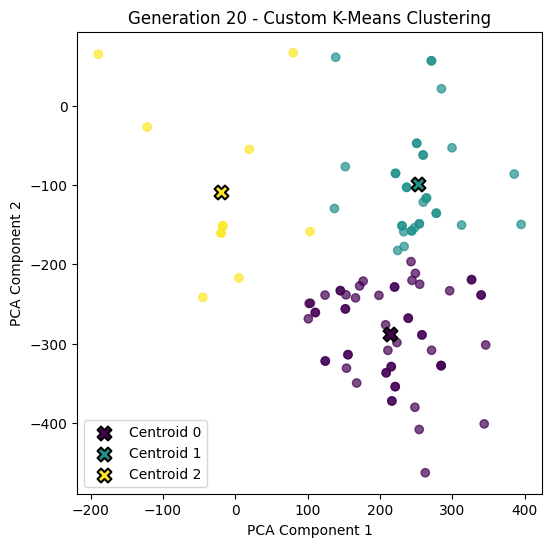

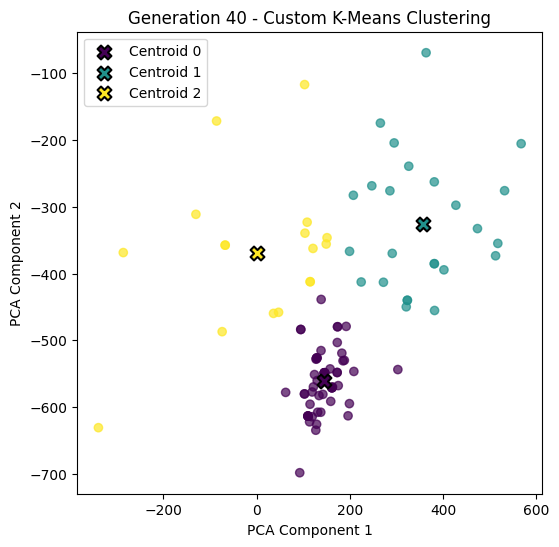

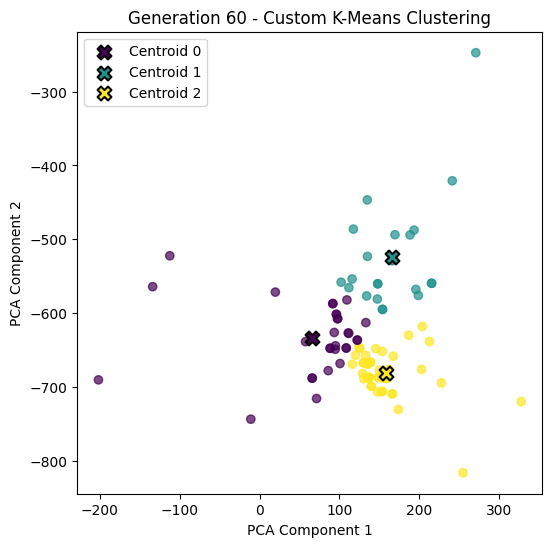

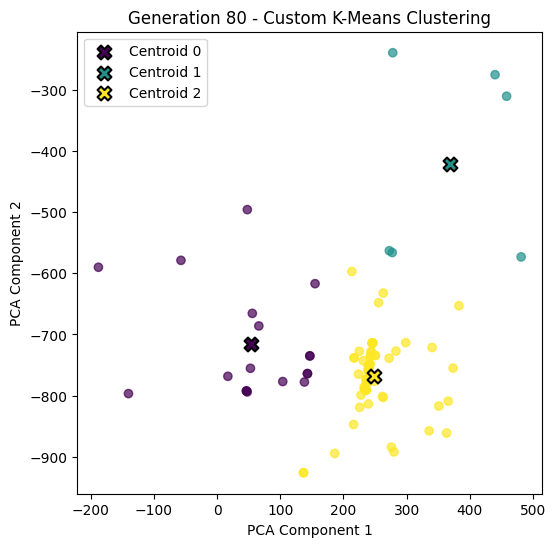

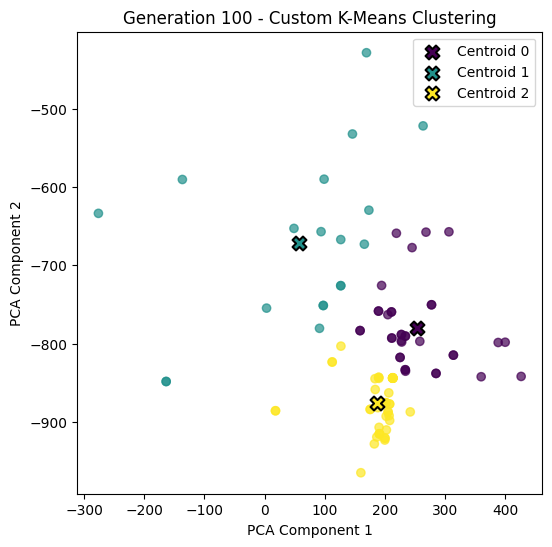

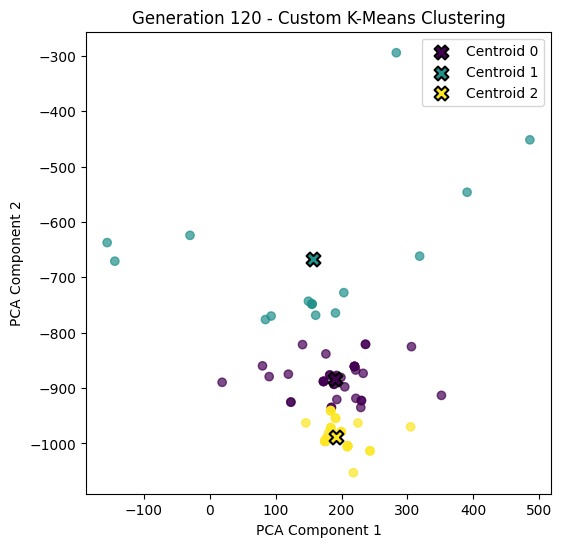

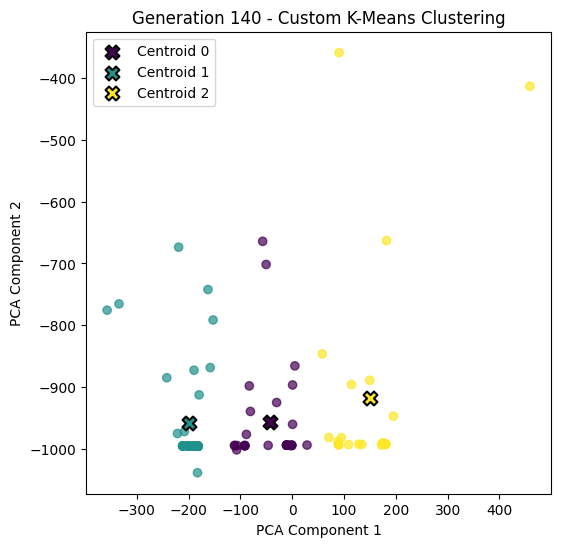

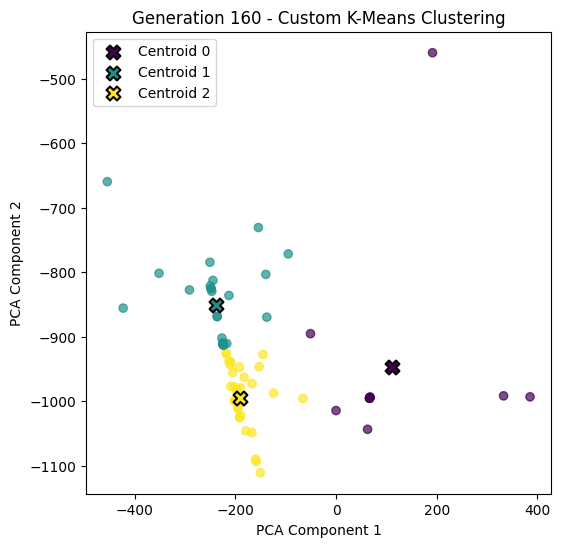

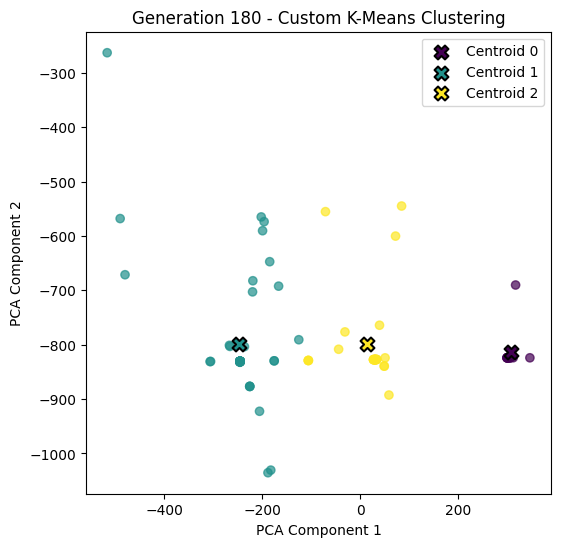

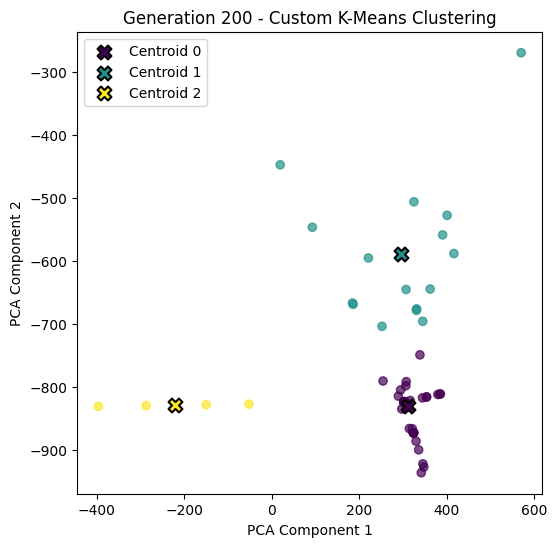

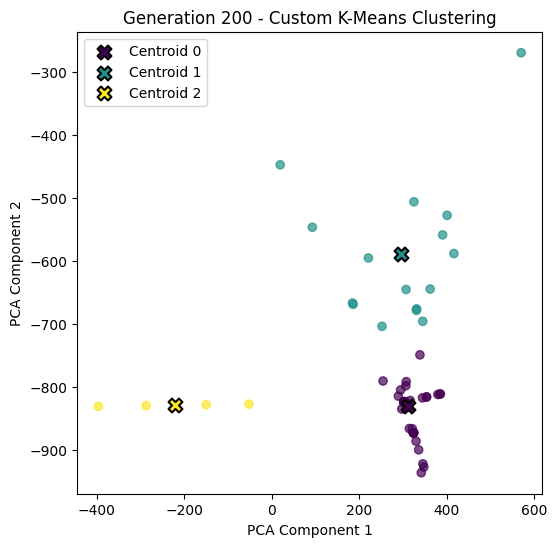

In [ ]:
run("population_log_GA.csv", 3, 20, sphere)